In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d amananandrai/ag-news-classification-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /content/gdrive/My Drive/Kaggle. Or use the environment method.


In [ ]:
!ls

gdrive	sample_data


In [ ]:
# !unzip \*.zip  && rm *.zip

!unzip \*ag-news-classification-dataset.zip && rm ag-news-classification-dataset.zip

unzip:  cannot find or open *ag-news-classification-dataset.zip, *ag-news-classification-dataset.zip.zip or *ag-news-classification-dataset.zip.ZIP.

No zipfiles found.


In [ ]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.optimizers import RMSprop

df = pd.read_csv('train.csv')
df

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
# Decided to use title and description coloumn as independent variable and merge that coloumns

df['text'] = df['Title'] + " " + df['Description']
df['class_index'] = df['Class Index']
df = df.drop(columns=['Title', 'Description', 'Class Index'])
df

,text,class_index
0,Wall St. Bears Claw Back Into the Black (Reute...,3
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,3
3,Iraq Halts Oil Exports from Main Southern Pipe...,3
4,"Oil prices soar to all-time record, posing new...",3
...,...,...
119995,Pakistan's Musharraf Says Won't Quit as Army C...,1
119996,Renteria signing a top-shelf deal Red Sox gene...,2
119997,Saban not going to Dolphins yet The Miami Dolp...,2
119998,Today's NFL games PITTSBURGH at NY GIANTS Time...,2


In [ ]:
# Cleaning the data from stopwords with some whitelist

nltk.download('stopwords')
def remove_stopwords(input_text):
        stopwords_list = stopwords.words('english')
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words) 
       
df.text = df.text.apply(remove_stopwords)
df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,text,class_index
0,Wall St. Bears Claw Back Into Black (Reuters) ...,3
1,Carlyle Looks Toward Commercial Aerospace (Reu...,3
2,Oil Economy Cloud Stocks' Outlook (Reuters) Re...,3
3,Iraq Halts Oil Exports Main Southern Pipeline ...,3
4,"Oil prices soar all-time record, posing new me...",3
...,...,...
119995,Pakistan's Musharraf Says Won't Quit Army Chie...,1
119996,Renteria signing top-shelf deal Red Sox genera...,2
119997,Saban not going Dolphins yet The Miami Dolphin...,2
119998,Today's NFL games PITTSBURGH NY GIANTS Time: 1...,2


In [ ]:
# Vizualisation/plot loss and accuracy function

def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

In [ ]:
# One-hot encoding

category = pd.get_dummies(df.class_index)
df_new = pd.concat([df, category], axis=1)
df_new = df_new.drop(columns='class_index')
df_new
# label : 1-World, 2-Sports, 3-Business, 4-Sci/Tech

,text,1,2,3,4
0,Wall St. Bears Claw Back Into Black (Reuters) ...,0,0,1,0
1,Carlyle Looks Toward Commercial Aerospace (Reu...,0,0,1,0
2,Oil Economy Cloud Stocks' Outlook (Reuters) Re...,0,0,1,0
3,Iraq Halts Oil Exports Main Southern Pipeline ...,0,0,1,0
4,"Oil prices soar all-time record, posing new me...",0,0,1,0
...,...,...,...,...,...
119995,Pakistan's Musharraf Says Won't Quit Army Chie...,1,0,0,0
119996,Renteria signing top-shelf deal Red Sox genera...,0,1,0,0
119997,Saban not going Dolphins yet The Miami Dolphin...,0,1,0,0
119998,Today's NFL games PITTSBURGH NY GIANTS Time: 1...,0,1,0,0


In [ ]:
# Separate attributes and labels

text = df_new['text'].values
label = df_new[[1, 2, 3, 4]]

In [ ]:
from sklearn.model_selection import train_test_split
text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
     
tokenizer = Tokenizer(num_words=10000, oov_token='x', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(text_train) 
tokenizer.fit_on_texts(text_test)

In [ ]:
# Sequencing and padding

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)
padded_train = pad_sequences(sequences_train) 
padded_test = pad_sequences(sequences_test)

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=10000, output_dim=16),
        tf.keras.layers.LSTM(128, return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 128)         74240     
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)               

In [ ]:
# (Callbacks) check the accuration of the model if already over 90% then stop training

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9):
      print("\nAccuration's reached > 90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 20
history = model.fit(padded_train, label_train, epochs=num_epochs, batch_size=512,
                    validation_data=(padded_test, label_test), verbose=1, callbacks=[callbacks])

Epoch 1/20
188/188 [==============================] - 377s 2s/step - loss: 0.7910 - accuracy: 0.6732 - val_loss: 0.3626 - val_accuracy: 0.8865
Epoch 2/20
188/188 [==============================] - 379s 2s/step - loss: 0.3696 - accuracy: 0.8969 - val_loss: 0.3109 - val_accuracy: 0.9024
Epoch 3/20
188/188 [==============================] - ETA: 0s - loss: 0.2927 - accuracy: 0.9176
Accuration's reached > 90%!
188/188 [==============================] - 374s 2s/step - loss: 0.2927 - accuracy: 0.9176 - val_loss: 0.2912 - val_accuracy: 0.9079


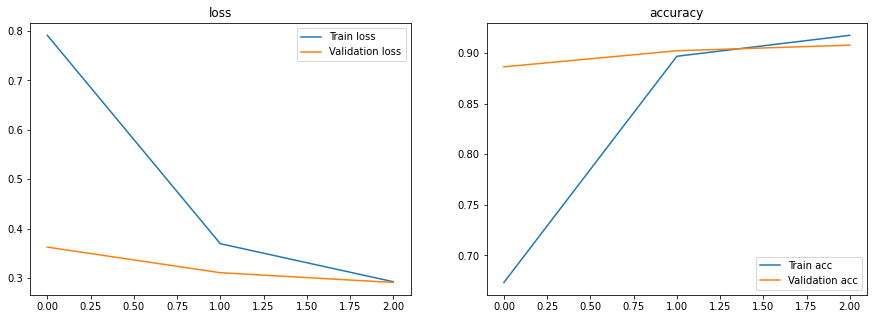

In [ ]:
show_final_history(history)
model_json = model.to_json()